# Inhibitory specificity
In this notebook we perform some analyses inspired by:
Schneider-Mizell et al., 2023. Cell-type-specific inhibitory circuitry from a connectomic census of mouse visual cortex. (https://www.biorxiv.org/content/10.1101/2023.01.23.525290v2.abstract)

That is, we analyze the targeting of inhibitory connections of the MICrONS cortical mm3 data (https://www.microns-explorer.org/cortical-mm3)

Note: Since this is just a demonstration, it is much more primitive than the actual analyses in the preprint!

### Requirements
To run this, you will need to download our Connectome-utilities version of the MICrONS mm3 connectome.
You can find it on Zenodo: 

> https://zenodo.org/record/8364070/files/microns_mm3_connectome.h5

Place the file under the path indicated below.

There are three inhibitory types classified in the data: BC, MC and NGC.
Other variables will be a cutoff for distances of synapses from the postsynaptic soma. Values below that value will indicate "proximal" innervation. And the x and z interval of a central subvolume to analyze. That is, we limit the analysis to neurons in an axis-aligned bounding box (300 x 300 um).

In [39]:
import numpy
import pandas
import conntility

fn = "./microns_mm3_connectome.h5"

M = conntility.ConnectivityMatrix.from_h5(fn, "full")

inh_types = ["BC", "MC", "NGC"]
cutoff_proximal = 100
interval_z = [700000, 1000000]
interval_x = [650000, 950000]

The next cell limits the data to the bounding box of interest. 10605 neurons remain.

In [40]:
M = M.index("x_nm").gt(interval_x[0]).index("x_nm").lt(interval_x[1]).index("z_nm").gt(interval_z[0]).index("z_nm").lt(interval_z[1])
print(len(M.vertices))

10605


### Out-degree
As a baseline of innervation, we calculate the outdegree of each neuron.
Note that the neurons in this dataset are already associated with their in- and out-degree. But here we want only the degrees from connections insider the subvolume we defined.

In [41]:
M.add_vertex_property("internal_outdegree",
                      numpy.array(M.compress().matrix.sum(axis=1))[:, 0])

### Fraction of proximal synapses
For each neuron, we consider its efferent synapses. Then calculate the fraction of them that are proximal according to the cutoff defined above. Note that this will also include synapses on the soma, and does not distinguish between basal and apical dendrites, unlike Schneider-Mizell et al.

Later, we will limit our analysis to only inhibitory neuron types, but since this calculation is so cheap, we might as well run it for all neurons.

In [81]:
# Step 1: For each synapse: is it proximal?
M.add_edge_property("is_proximal", M.edges["soma_offset_um"].values < cutoff_proximal)
C = M.compress({ # Step 2: For each neuron pair: Number of synapses between them that are proximal
    "count_proximal": ("is_proximal", "sum")
}).default("count_proximal")
# Step 3: Sum over connections of a neuron, divided by the total degree gives us a fraction.
M.add_vertex_property("frac_proximal", numpy.array(C.matrix.sum(axis=1))[:, 0] / C.vertices["internal_outdegree"].values)

### Fraction of synapses on inhibitory types
Similar to the above, but for innervation of inhibitory types. Once again, we run it for all types, because it is so cheap.

In [ ]:
M.add_edge_property("is_inh", M.edge_associated_vertex_properties("cell_type")["col"].isin(inh_types).values)
C = M.compress({
    "count_inhibitory": ("is_inh", "sum")
}).default("count_inhibitory")
M.add_vertex_property("frac_inh", numpy.array(C.matrix.sum(axis=1))[:, 0] / C.vertices["internal_outdegree"].values)

### Fraction of connections that are multi-synaptic
For this one we generate a sparse matrix of synapses per connection. Then divide the count of connections where the value is > 1 by the count of connections (we could also use the "internal_outdegree" property for the second part).

In [44]:
mat = C.default("count").matrix
M.add_vertex_property("frac_multi", numpy.array((mat > 1).sum(axis=1) / (mat > 0).sum(axis=1))[:, 0])

/tmp/ipykernel_16274/3085460659.py:2: RuntimeWarning: invalid value encountered in divide
  M.add_vertex_property("frac_multi", numpy.array((mat > 1).sum(axis=1) / (mat > 0).sum(axis=1))[:, 0])


### Fraction of synapses that are "clumped"
Synapses are considered "clumped" if they are within 15 um of a synapse of the same connection (i.e. between the same pair of neurons).
This analysis is a bit more expensive, so we run it only for the inhibitory types we are interested in. 

In [82]:
from scipy.spatial import distance

# We use the following edge properties to calculate distances between synapses. These are their locations relative to the postsynaptic soma.
cols_loc = ["delta_x_nm", "delta_y_nm", "delta_z_nm"]

# Assemble all the data we need into a single dataframe
df = pandas.concat([M._edge_indices.reset_index(drop=True), # Indices of pre- and post-neuron. To group synapses together by connection 
                    M.edges[cols_loc].reset_index(drop=True), # Their locations. See above.
                    M.edge_associated_vertex_properties("cell_type")["row"].rename("pre_type")], # Cell types of pre-synaptic neurons.
                   axis=1)

# We use the cell type of the presynaptic neuron to filter for our inhibitory population of interest.
inh_df = df.loc[df["pre_type"].isin(inh_types)]

In [67]:
# A function that calculates the number of clumped synapses in a connection from a dataframe of locations
def count_clumped(subdf, cutoff=15000):
    D = distance.squareform(distance.pdist(subdf[cols_loc]))
    return numpy.any((D < cutoff) & (D > 0), axis=0).sum()

# Group and apply. This takes a while.
sum_clumped = inh_df.groupby(["row", "col"]).apply(count_clumped)

The result is a dataframe with the count of clumped synapses, indexed by connection. We sum the result over presynaptic neurons and then divide by their total degree. Alternatively, we divide by the total degree in multi-synaptic connections. That analysis might be more meaningful, because a single-synaptic connection cannot be "clumped" by definition.

In [70]:
per_neuron_clumped = sum_clumped.groupby("row").sum().reindex(range(len(M.vertices)))
M.add_vertex_property("frac_clumped", per_neuron_clumped.values / M.vertices["internal_outdegree"].values)
M.add_vertex_property("frac_multi_clumped",
                      per_neuron_clumped.values / numpy.array(mat.sum(axis=1) - (mat == 1).sum(axis=1))[:, 0])

/tmp/ipykernel_16274/402842692.py:4: RuntimeWarning: invalid value encountered in divide
  per_neuron_clumped.values / numpy.array(mat.sum(axis=1) - (mat == 1).sum(axis=1))[:, 0])


Schneider-Mizell et al. used many additional parameters and clustered the results into classes.
Here, we simply plot the results for each of the inhibitory classes. We can then see if some of the observed trends are at least partially recreated.

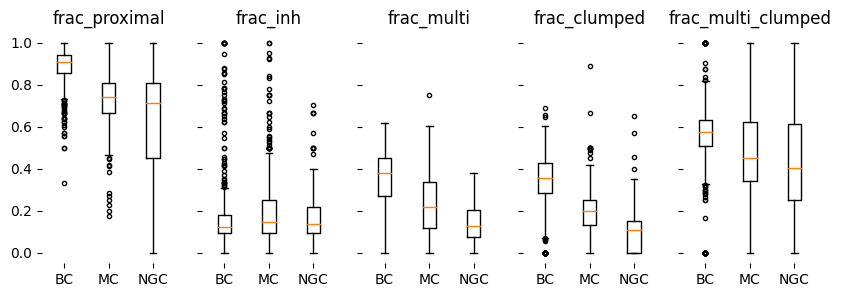

In [95]:
from matplotlib import pyplot as plt

cols_of_interest = ["frac_proximal", "frac_inh", "frac_multi", "frac_clumped", "frac_multi_clumped"]
df = M.vertices.set_index("cell_type").loc[inh_types][cols_of_interest].dropna(axis=0, how="all")

fig = plt.figure(figsize=(10, 3))
# ax = fig.gca()

for i, col in enumerate(df.columns):
    plotme = df[col].groupby("cell_type").apply(lambda _x: list(_x[~numpy.isnan(_x)]))
    ax = fig.add_subplot(1, len(df.columns), i + 1)
    ax.boxplot(plotme.values, #positions=numpy.linspace(-0.25, 0.25, len(inh_types)) + i,
              sym='.', labels=plotme.index)
    ax.set_title(col)
    ax.set_ylim([-0.05, 1.05])
    if i > 0: ax.set_yticklabels([])
    ax.set_frame_on(False)


Schneider-Mizell et al. found a proximally targeting type and identified it as mostly BCs. Here, we find that the fraction of proximal synapses is largest for BCs.

Schneider-Mizell et al. found a sparsely (i.e. non-multi-synaptic) targeting class and identified it as NGCs and L1 neurons. Here, we find that the fraction of multi-synaptic connections is lowest for NGCs. 

Schneider-Mizell et al. found an inhibitory targeting class and identified it as VIP-positive neurons. There is no corresponding class in this dataset, but we note the presence of many outliers in the "fraction inhibitory" metric. In the next cell we will look at them more closely.

What surprises me is that the fraction proximal for (tentative) MCs is so high. This comprises in this analysis synapses on proximal dendrites and somata. Still, the value for MCs should be below 50%.

Finding "inhibitory targeting" neurons. We consider every neuron more than 2 standard deviations over the median value.

In [92]:
cutoff = df["frac_inh"].median() + 2 * df["frac_inh"].std()
display(df.loc[df["frac_inh"] >= cutoff].reset_index()["cell_type"].value_counts())
display(100 * (df["frac_inh"] >= cutoff).mean()) 

cell_type
BC     37
MC     34
NGC     9
Name: count, dtype: int64

8.130081300813007

We find that they are classified here as mostly  MC and BC. Also they make up around 8% of the population. Somewhat comparable to the reference, where it's 12% of the population.